In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/rows.csv.zip

Archive:  /content/drive/MyDrive/rows.csv.zip
  inflating: rows.csv                


In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [4]:
print(os.listdir())

['.config', 'rows.csv', 'drive', 'sample_data']


In [5]:
# loading data
df = pd.read_csv('/content/rows.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.shape

(1282355, 18)

In [7]:
df.head(3).T

,0,1,2
Date received,05/10/2019,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account,Debt collection
Sub-product,Checking account,Other banking product or service,Payday loan debt
Issue,Managing an account,Managing an account,Communication tactics
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals,Frequent or repeated calls
Consumer complaint narrative,NaN,NaN,NaN
Company public response,NaN,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION,CURO Intermediate Holdings
State,FL,WA,TX
ZIP code,328XX,98204,751XX


In [8]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

print(df1.shape)

df1.head(2).T

(383564, 2)


,29904,30629
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Consumer_complaint,The Summer of XX/XX/2018 I was denied a mortga...,There are many mistakes appear in my report wi...


In [9]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Student loan'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit card'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [10]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [11]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


In [12]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


In [13]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


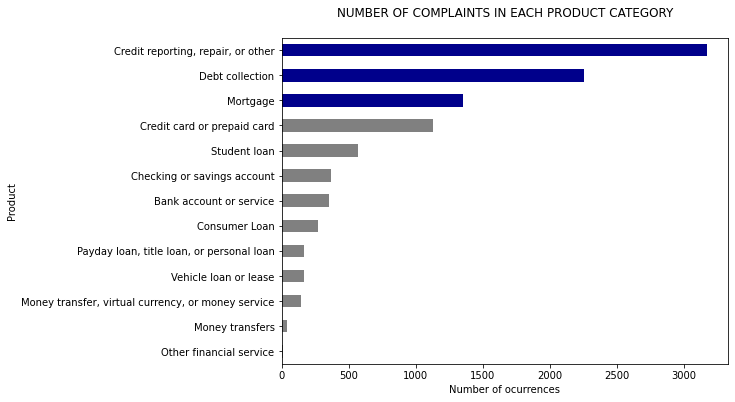

In [14]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [16]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection agency


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: ethereum, bitcoin, coinbase
  * Most Correlated Bigrams are: account coinbase, coinbase xxxx, coinbase account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: paypal, moneygram, gram
  * Most Correlated Bigrams are: sending money, western union, money gram


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: short sale, mortgage company, loan modification


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: meetings, productive, vast
  * Most Correlated Bigrams are: insurance check, check payable, face face


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: astra, ace, payday
  * Most Correlated Bigrams are: 00 loan, applied payday, payday loan


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: student, loans, navient
  * Most Correlated Bigrams are: income based, student loan, student loans

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: honda, car, vehicle
  * Most Correlated Bigrams are: used vehicle, total loss, honda financial


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7641,0.009839
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3949,0.006665


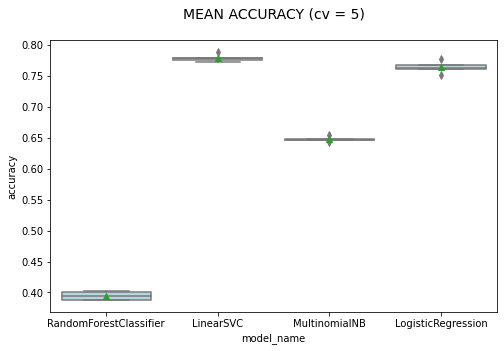

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [21]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


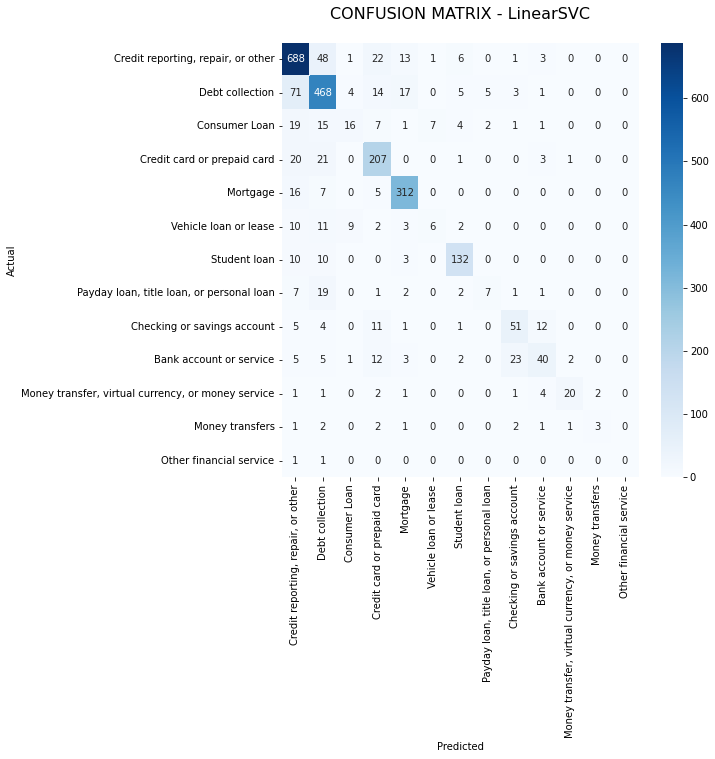

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [28]:
complaint = """I have received over 27 emails from XXXX XXXX who is a representative from Midland Funding LLC. 
From XX/XX/XXXX I received approximately 6 emails. From XX/XX/XXXX I received approximately 6 emails. 
From XX/XX/XXXX I received approximately 9 emails. From XX/XX/XXXX I received approximately 6 emails. 
All emails came from the same individual, XXXX XXXX. It is becoming a nonstop issue of harassment."""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Debt collection']


In [29]:
complaint = """Respected Sir/ Madam, I am exploring the possibilities for financing my daughter 's 
XXXX education with private loan from bank. I am in the XXXX on XXXX visa. 
My daughter is on XXXX dependent visa. As a result, she is considered as international student. 
I am waiting in the Green Card ( Permanent Residency ) line for last several years. 

I checked with Discover, XXXX XXXX websites. While they allow international students to apply for loan, they need 
cosigners who are either US citizens or Permanent Residents. I feel that this is unfair. 
I had been given mortgage and car loans in the past which I closed successfully. I have good financial history. 
I think I should be allowed to remain cosigner on the student loan. I would be much obliged if you could look into it. 
Thanking you in advance. Best Regards"""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Student loan']


In [30]:
complaint = """They make me look like if I was behind on my Mortgage on the month of XX/XX/2018 & XX/XX/XXXX 
when I was not and never was, when I was even giving extra money to the Principal. 
The Money Source Web site and the managers started a problem, when my wife was trying to increase the payment, 
so more money went to the Principal and two payments came out that month and because 
I reverse one of them thru my Bank as Fraud they took revenge and committed slander against me by reporting me late at the Credit Bureaus, 
for 45 and 60 days, when it was not thru. Told them to correct that and the accounting department or the company revert 
that letter from going to the Credit Bureaus to correct their injustice. The manager by the name XXXX requested this for 
the second time and nothing yet. I am a Senior of XXXX years old and a Retired XXXX Veteran and is a disgraced that Americans 
treat us that way and do not want to admit their injustice and lies to the Credit Bureau."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Mortgage']
